In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, make_scorer, fbeta_score,accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from time import time
from sklearn.linear_model import RidgeCV
import scikitplot as skplt
import plotly.express as px
import folium
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier , plot_tree
# import eli5 
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin

random_state=42

In [2]:
data_df = pd.read_csv('hotel_bookings.csv')
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.options.display.max_rows = 200000
data_df = data_df.drop(columns=['reservation_status_date', 'hotel', 'reservation_status',
    'arrival_date_week_number', 'reserved_room_type', 'company'])

data_df['Total Guests'] = data_df['adults'] + data_df['children'] + data_df['babies']
data_df['price_per_guest'] = data_df['adr']/data_df['Total Guests']

filter = (data_df.children == 0) & (data_df.adults == 0) & (data_df.babies == 0)
data_df[filter]
data_df = data_df[~filter]
data_df.shape

(119210, 28)

In [3]:
# data_df.columns.to_list()

In [3]:
nan_replacements = {"children": 0.0, "agent": 0, "country": 'unknown', 'Total Guests':0, 'price_per_guest':0}
data_df = data_df.fillna(nan_replacements)
# data_df.info()

In [7]:
# data_df.describe()

In [6]:
# data_df['price_per_guest'].sort_values()

In [4]:
# czy usunąć też: data_df['price_per_guest'] ==0???

data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
data_df.dropna(inplace=True)

data_df.drop(14969)
data_df.shape

(119210, 28)

In [5]:
# funkcja zwracająca cechy numeryczne
def get_quant_features(dataframe):
    feats = dataframe.select_dtypes([np.number, np.bool]).columns
    return [x for x in feats]

# funkcja rysująca histogramy dla numerycznych cechy
def draw_histograms(dataframe, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(16,10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        dataframe[var_name].hist(bins=20,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

C:\Users\iwona\AppData\Local\Temp/ipykernel_25300/3624076162.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  feats = dataframe.select_dtypes([np.number, np.bool]).columns


20


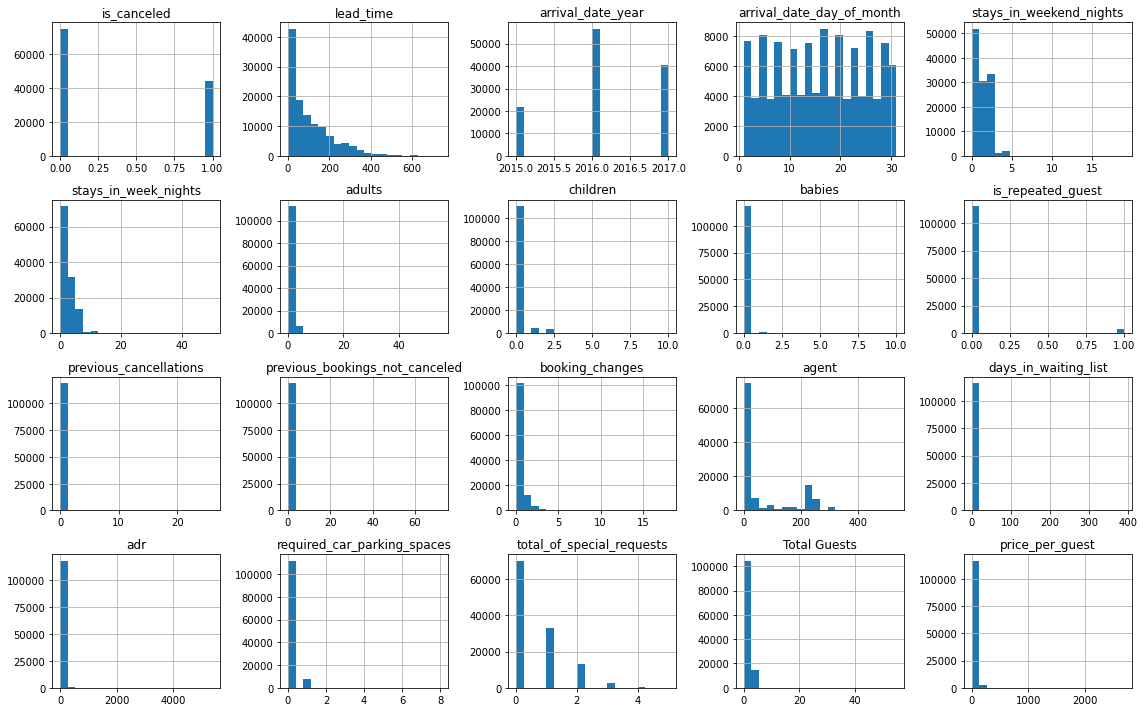

In [6]:
feats = get_quant_features(data_df)
print(len(feats))
draw_histograms(data_df, feats, 4, 5)

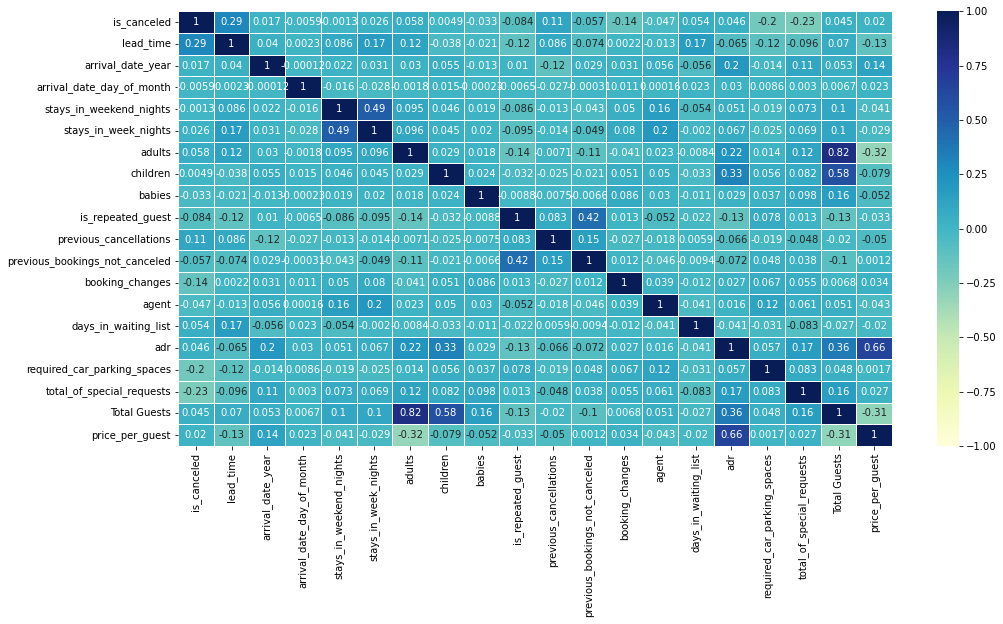

In [10]:
plt.rcParams['figure.figsize']=(16,8)
sns.heatmap(data_df.corr(method='pearson',), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

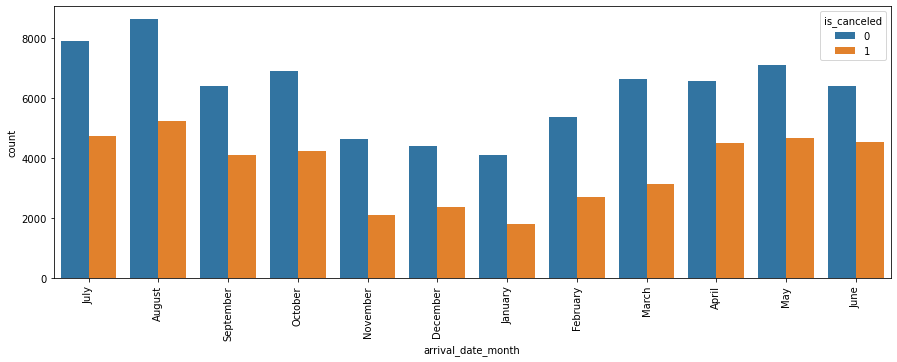

In [11]:
plt.figure(figsize=(15, 5))
sns.countplot(x='arrival_date_month', hue='is_canceled', data=data_df)
plt.xticks(rotation=90);

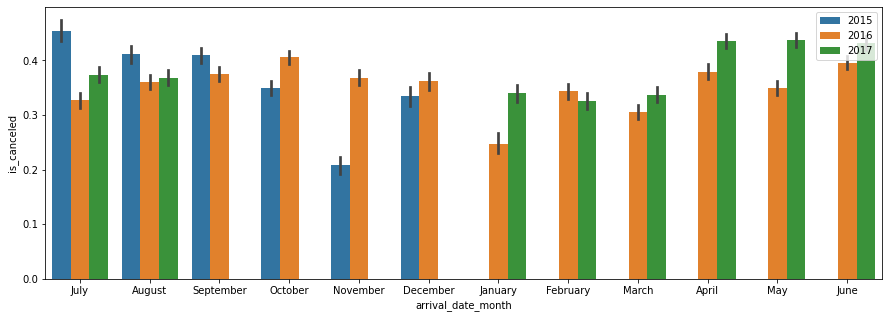

In [12]:
plt.figure(figsize=(15,5))
sns.barplot(x='arrival_date_month', y='is_canceled', hue='arrival_date_year', data=data_df)
plt.legend(loc='upper right');

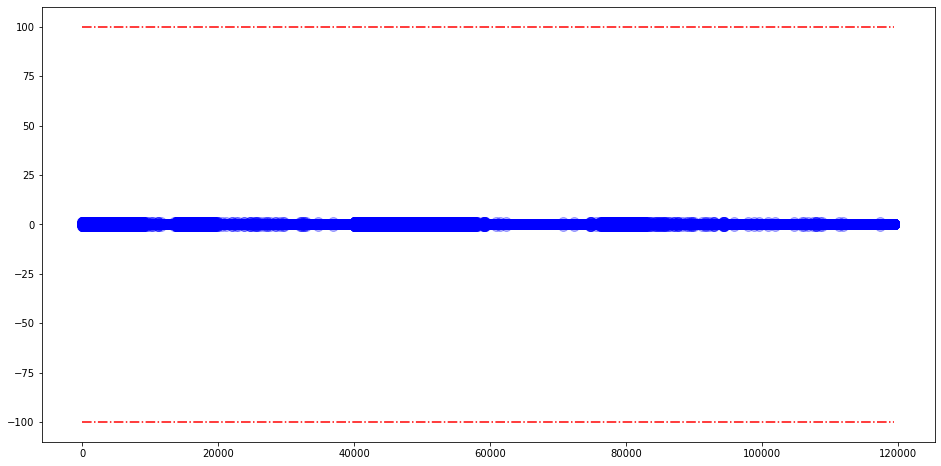

In [13]:
# sprawdzamy, czy są jakieś wartości odstające
# pd.diff() sprawdza różnice co do poprzedniego elementu
plt.plot(data_df.index, data_df['is_canceled'].diff(), 'bo', alpha=0.3, ms=10, lw='3')

plt.hlines(xmin=data_df.index.min(), xmax=data_df.index.max(), y=100, color='r', linestyle='-.')
plt.hlines(xmin=data_df.index.min(), xmax=data_df.index.max(), y=-100, color='r', linestyle='-.');

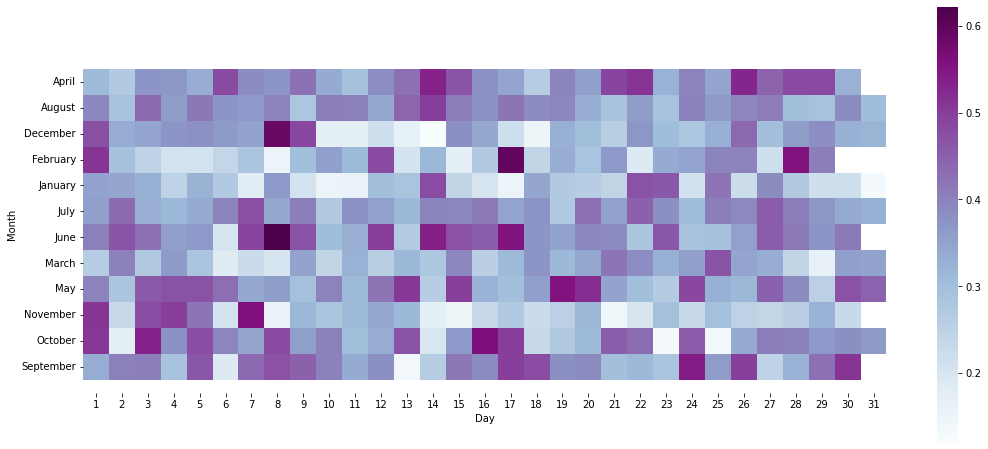

In [14]:
plt.figure(figsize=(18, 8))

# heatmap dla średniej PM2.5 dla godzin i miesięcy
df_train = data_df.groupby(['arrival_date_month', 'arrival_date_day_of_month'])["is_canceled"].mean().reset_index()
df_train = df_train.pivot('arrival_date_month', 'arrival_date_day_of_month', "is_canceled")
ax = sns.heatmap(df_train, cmap="BuPu", square=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel('Day')
plt.ylabel('Month');

In [16]:
# data_df = pd.get_dummies(data_df)
# data_df.shape

(119210, 246)

In [5]:
features = data_df.drop(columns=['is_canceled','Total Guests'], axis=1).columns.to_list()
# features

In [25]:
# data_df.isna().any()

In [6]:
x = data_df[features]
y = data_df['is_canceled']
# y = np.array(data_df['is_canceled'])

sep_cat= []
sep_num = []
for n in features:
    if data_df[n].dtype == object:
        sep_cat.append(n)
    else:
        sep_num.append(n)



In [ ]:
# x_train, x_rest, y_train, y_rest = train_test_split(x, y, test_size=0.40, random_state = 42)
# x_val, x_test, y_val, y_test = train_test_split(x, y, test_size=0.50, random_state = 42)

In [7]:
class DenseTransformer(TransformerMixin):

    def fit(self, x, y=None, **fit_params):
        return self

    def transform(self, x, y=None, **fit_params):
        return x.todense()

In [8]:
# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value and here no dates are missing.
sep_num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
sep_cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore')),
    ('to_dense', DenseTransformer())])

# Bundle preprocessing for numerical and categorical features:
datacleaner = ColumnTransformer(transformers=[("num", sep_num_transformer, sep_num),
                                              ("cat", sep_cat_transformer, sep_cat)],remainder = 'passthrough')


In [9]:
# import warnings 
# warnings.filterwarnings('ignore')

# define models to test:
models = [("Dummy_Model:",DummyClassifier(strategy="stratified")),
            ("DecisionTree_Model", DecisionTreeClassifier(random_state=42)),
            ("RandomForest_Model", RandomForestClassifier(random_state=42)),
            ("LogisticRegression_Model", LogisticRegression(random_state=42, solver='liblinear')),
            ("XGBBoost_Model", XGBClassifier(random_state=42,use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)),
            ("Gaussian_Model", GaussianNB()),
            ("KNN_Model", KNeighborsClassifier())]


# split data into 'kfolds' parts for cross validation,
# use shuffle to ensure random distribution of data:
kfolds = 4 # 4 = 75% train, 25% validation
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
fbeta_scorer = make_scorer(fbeta_score, beta=0.5)
# Preprocessing, fitting, making predictions and scoring for every model:
for name, model in models:
    # pack preprocessing of data and the model in a pipeline:
    model_steps = Pipeline(steps=[('datacleaner', datacleaner), ('model', model)])
    start = time()
    cv_results = cross_val_score(model_steps, x, y, cv=split, scoring="accuracy")
    fbeta_res = cross_val_score(model_steps, x, y, cv=split, scoring=fbeta_scorer)
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    fbeta_score = round(np.mean(fbeta_res), 4)
    std_dev = round(np.std(cv_results), 4)
    end = time()
    cross_val_time = round(end-start,4)
    print(f"{name}  f-beta: {fbeta_score}, accuracy score: {mean_score}, time: {cross_val_time}")


Dummy_Model:  f-beta: 0.3675, accuracy score: 0.5299, time: 2.9006
DecisionTree_Model  f-beta: 0.8087, accuracy score: 0.859, time: 25.5436
RandomForest_Model  f-beta: 0.8732, accuracy score: 0.8915, time: 172.5804
LogisticRegression_Model  f-beta: 0.7737, accuracy score: 0.8143, time: 13.9141
XGBBoost_Model  f-beta: 0.8451, accuracy score: 0.877, time: 113.3344
Gaussian_Model  f-beta: 0.4894, accuracy score: 0.5321, time: 6.6208
KNN_Model  f-beta: 0.7031, accuracy score: 0.776, time: 502.0235


In [20]:
# model = LogisticRegression(solver='liblinear')
# model.fit(x_train, y_train)

# y_pred = model.predict(x_test)

In [25]:
# print("Raport klasyfikacyjny:\n", classification_report(y_test, y_pred))
# print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
# print("Precision:", metrics.precision_score(y_test, y_pred))
# print("Recall:", metrics.recall_score(y_test, y_pred))
# print("Fbeta:", metrics.fbeta_score(y_test, y_pred, beta=0.5))

In [10]:
# cf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

# group_names = ['True Neg','False Pos','False Neg','True Pos']
# group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()] #flatten() 'splaszcza' matryce

# labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_counts)]
# labels = np.asarray(labels).reshape(2,2)

# sns.set(rc={'figure.figsize':(8,6)})
# ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
# ax.set(xlabel='Predicted', ylabel='Actual');

In [11]:
# plot_roc_curve(model, x_train, y_train)
# pass

In [12]:
# skplt.estimators.plot_learning_curve(model, x, y)

# plt.show()

In [ ]:
# ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(x, y)
# importance = np.abs(ridge.coef_)
# feature_names = np.array(x.columns)
# feature_names.shape

# plt.bar(height=importance, x=feature_names)
# plt.title("Feature importances via coefficients")
# plt.show()

# from sklearn.feature_selection import SelectFromModel
# from time import time

# threshold = np.sort(importance)[-120] + 0.01

# tic = time()
# sfm = SelectFromModel(ridge, threshold=threshold).fit(x, y)
# toc = time()
# print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
# print(f"Done in {toc - tic:.3f}s")

In [ ]:
# x_n = data_df[feature_names[sfm.get_support()]]
# y_n = np.array(data_df['is_canceled'])

# x_train_n, x_rest_n, y_train_n, y_rest_n = train_test_split(x_n, y_n, test_size=0.40, random_state = 2022)
# x_val_n, x_test_n, y_val_n, y_test_n = train_test_split(x_n, y_n, test_size=0.50, random_state = 2022)

# model2 = LogisticRegression(solver='liblinear')
# model2.fit(x_train_n, y_train_n)

# y_pred_n = model2.predict(x_test_n)

# print("Raport klasyfikacyjny:\n", classification_report(y_test_n, y_pred_n))
# print("Accuracy:", metrics.accuracy_score(y_test_n, y_pred_n))
# print("Precision:", metrics.precision_score(y_test_n, y_pred_n))
# print("Recall:", metrics.recall_score(y_test_n, y_pred_n))
# print("Fbeta:", metrics.fbeta_score(y_test_n, y_pred_n, beta=0.5))

# plot_roc_curve(model2, x_train_n, y_train_n)
# pass

In [ ]:
# from sklearn.feature_selection import SequentialFeatureSelector

# tic_fwd = time()
# sfs_forward = SequentialFeatureSelector(
#     ridge, n_features_to_select=2, direction="forward"
# ).fit(x, y)
# toc_fwd = time()

# tic_bwd = time()
# sfs_backward = SequentialFeatureSelector(
#     ridge, n_features_to_select=2, direction="backward"
# ).fit(x, y)
# toc_bwd = time()

# print(
#     "Features selected by forward sequential selection: "
#     f"{feature_names[sfs_forward.get_support()]}"
# )
# print(f"Done in {toc_fwd - tic_fwd:.3f}s")
# print(
#     "Features selected by backward sequential selection: "
#     f"{feature_names[sfs_backward.get_support()]}"
# )
# print(f"Done in {toc_bwd - tic_bwd:.3f}s")

In [ ]:
# scaler = StandardScaler()
# X_std = scaler.fit_transform(x)

# x_train_std, x_rest_std, y_train_std, y_rest_std = train_test_split(X_std, y, test_size=0.40, random_state = 2022)
# x_val_std, x_test_std, y_val_std, y_test_std = train_test_split(X_std, y, test_size=0.50, random_state = 2022)

# # Perform GridSearchCV to tune best-fit LR model
# parameters = {'C': [10**-2,10**-1,10**0,10**1,10**2], 'penalty': ['l1','l2']}

# # lr_model = LogisticRegression(penalty='l1', solver='liblinear')
# gs_model = GridSearchCV(estimator=model, param_grid=parameters)
# gs_model.fit(x_train_std, y_train)
# gs_model

# # Train a LR model with best parameters
# model = LogisticRegression(**gs_model.best_params_, solver='liblinear')
# model.fit(x_train_std, y_train)